# Debug the Calculation of Stroke Error

In [1]:
import os
import xmltodict

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image, ImageDraw
from random import randint, seed
from xmlparse import xmlToGeometry, loadGeometry

import numpy as np

In [2]:
def loadRef(han_char, ref_dir = "Reference"):
    stroke_list = []
    frac_dists = []
    ref_path = f"{ref_dir}/{han_char[0]}000/{han_char}.han"
    ref_xml = open(ref_path, "r").read()
    root = xmltodict.parse(ref_xml)
    bounds = root["hanDefinition"]["bounds"]
    x_min, y_min, x_max, y_max = (float(bounds["@left"]), float(bounds["@bottom"]), float(bounds["@right"]), float(bounds["@top"]))
    scale = (int(x_max-x_min), int(y_max-y_min))
    strokes = root["hanDefinition"]["strokes"]["stroke"]
    for stroke in strokes:
        points = stroke["points"]["forward"]
        point_arr = []
        frac_arr = []
        for point in points["pointDistance"]:
            point_arr.append((float(point["@x"])-x_min,
                              float(point["@y"])-y_min))
            frac_arr.append(float(point["@fractionalDistance"]))
        stroke_list.append(np.array(point_arr))
        frac_dists.append(np.array(frac_arr))
    return stroke_list, frac_dists, scale


In [3]:
ref_g, ref_l, output_size = loadRef("56DB", "Reference")
# in order to test multiple samples, add the file numbers to the f_read list and delete the [0] at the line end
# be aware this will turn g and l into iterables, so handle your loops accordingly
g, l = loadGeometry("Genes/maint_0.001 on 56DB.08/", "56DB", output_size, f_read = ["56DB.08.15.gene"])[0]

In [4]:
def alignStrokes(strokes, ref, p_strokes, p_ref):
    # function to get stroke length given a stroke value (in this case, a stroke value is a 2d list
    # that contains an x coord in stroke[][0] and a y coord in stroke[][1])
    def getStrokeLen(stroke):
        length = 0 # adding all the lengths we get between two points to this variable
        # while it looks a little complicated, this is just the pythagorean theorem applied between two coordinates, just 
        # how one would calculate it on a graph: sqrt(a^2 + b^2)
        for i in range(len(stroke)-1):
            length += ((stroke[i][0] - stroke[i+1][0])**2 + (stroke[i][1] - stroke[i+1][1])**2)**0.5
        return length

    #get the lengths of each stroke for the order in the greedy algorithm
    ref_lengths = []
    for i in range(len(strokes)):
        ref_lengths.append(getStrokeLen(ref[i]))
    priority = np.argsort(ref_lengths)[::-1]
    
    strokes = strokes
    p_strokes = p_strokes
    ref = ref
    p_ref = p_ref
    
    error_maps = strokeErrorMatrix(strokes, ref, p_strokes, p_ref)
    
    print(error_maps.astype(int))

    # -1 just means unmatched here since 0 (the other 'default' filler) is a meaningful number in this context
    stroke_map = np.full(len(strokes), -1)

    
    for i in priority:
        largestref = i # this is the index for the reference stroke that is largest
        smallerror = np.argmin(error_maps[largestref, :]) # access the error map from the largest stroke's index and see which error is smallest
        print(f"{error_maps.astype(int)[i]} - minimizing for priority stroke {i}")
        error_maps[:, smallerror] = 10000
        print("Resulting error map:")
        print(error_maps.astype(int))
        stroke_map[smallerror] = largestref # set the index in the stroke_map to the reference stroke we designated
        print(stroke_map)
    
    return stroke_map

xcolors = ["#7e1e9c", "#15b01a", "#0343df", "#653700", "#e50000", "#f97306", "#033500", "#ffff14", "#001146"]
color_selection = [(int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)) for c in xcolors]
colors = color_selection[:len(ref_l)+1]

def strokeErrorMatrix(strokes, ref, p_strokes, p_ref):
    error_map = np.zeros((len(ref), len(strokes)), dtype=float)
    for i, ref_stroke, r_progresses in zip(range(len(ref)), ref, p_ref):
        for j, candidate_stroke, c_progresses in zip(range(len(strokes)), strokes, p_strokes):
            error_map[i, j] = strokeError(ref_stroke, candidate_stroke, r_progresses, c_progresses)
            print(f"Ref stroke {i} vs Candidate Stroke {j} - error: {error_map[i, j]}")
            img = Image.new(mode="RGBA", size=output_size)
            draw = ImageDraw.Draw(img)
            for a in range(len(ref_stroke)-1):
                x1, y1 = ref_stroke[a]
                x2, y2 = ref_stroke[a+1]
                y1 = -(y1-output_size[1]/2)+output_size[1]/2
                y2 = -(y2-output_size[1]/2)+output_size[1]/2
                draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[0])
            for b in range(len(candidate_stroke)-1):
                x1, y1 = candidate_stroke[b]
                x2, y2 = candidate_stroke[b+1]
                y1 = -(y1-output_size[1]/2)+output_size[1]/2
                y2 = -(y2-output_size[1]/2)+output_size[1]/2
                draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[1])
            display(img)
    return error_map

def strokeError(stroke, ref_stroke, p_stroke, p_ref, mode="max"):
    forward_stroke_error, back_stroke_error = np.zeros(len(ref_stroke)), np.zeros(len(ref_stroke))
    forward_ref_error, back_ref_error = np.zeros(len(stroke)), np.zeros(len(stroke))
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke, p_ref):
        forward_stroke_error[i] = (np.linalg.norm(abs(rpoint-strokeTrace(stroke, p_stroke, rprogress))))
        #print(i, rpoint, strokeTrace(stroke, p_stroke, rprogress), forward_stroke_error[i])
    #print(f"Final forward stroke error: {forward_stroke_error.max()}")
    for i, rpoint, rprogress in zip(range(len(ref_stroke)), ref_stroke[::-1], p_ref[::-1]):
        back_stroke_error[i] = (np.linalg.norm(abs(rpoint-strokeTrace(stroke, p_stroke, 1-rprogress))))
        #print(i, rpoint, strokeTrace(stroke, p_stroke, 1-rprogress), back_stroke_error[i])
    #print(f"Final back stroke error: {back_stroke_error.max()}")
    for i, point, progress in zip(range(len(stroke)), stroke, p_stroke):
        forward_ref_error[i] = (np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, progress))))
        #print(i, point, strokeTrace(stroke, p_stroke, progress), forward_ref_error[i])
    #print(f"Final forward ref error: {forward_ref_error.max()}")
    for i, point, progress in zip(range(len(stroke)), stroke[::-1], p_stroke[::-1]):
        back_ref_error[i] = (np.linalg.norm((point-strokeTrace(ref_stroke, p_ref, 1-progress))))
        #print(i, point, strokeTrace(stroke, p_stroke, 1-progress), back_ref_error[i])
    #print(f"Final back ref error: {back_ref_error.max()}")
    fse_maxdev = forward_stroke_error.argmax()
    bse_maxdev = back_stroke_error.argmax()
    fre_maxdev = forward_ref_error.argmax()
    bre_maxdev = back_ref_error.argmax()
    final_error = max(min(forward_stroke_error.max(), back_stroke_error.max()), min(forward_ref_error.max(), back_ref_error.max()))
    #print(f"Final error: {final_error}")
    return final_error

def strokeTrace(stroke, stroke_progresses, progress):
    if progress == 1:
        return stroke[-1]
    progress_line = len(stroke_progresses)-1
    for i in range(1, len(stroke_progresses)):
        if stroke_progresses[i] > progress:
            progress_line = i-1
            break
    startp, endp = stroke_progresses[progress_line], stroke_progresses[progress_line+1]
    norm_progress = (progress-startp)/endp
    if stroke[progress_line+1][0] == stroke[progress_line][0]:
        x = stroke[progress_line][0]
        y = norm_progress*(stroke[progress_line+1][1]-stroke[progress_line][1])+stroke[progress_line][1]
    else:
        slope = (stroke[progress_line+1][1]-stroke[progress_line][1])/(stroke[progress_line+1][0]-stroke[progress_line][0])
        intercept = stroke[progress_line][1]-slope*stroke[progress_line][0]
        x = norm_progress*(stroke[progress_line+1][0]-stroke[progress_line][0])+stroke[progress_line][0]
        y = slope*x + intercept
    return np.array((x, y))


Ref stroke 0 vs Candidate Stroke 0 - error: 229.14326527133463


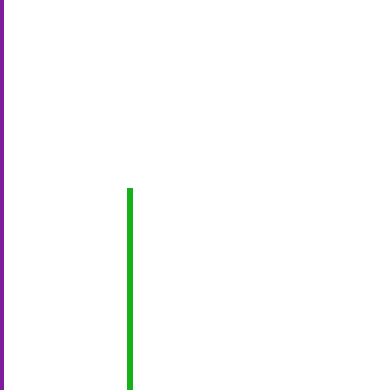

Ref stroke 0 vs Candidate Stroke 1 - error: 344.99967600557073


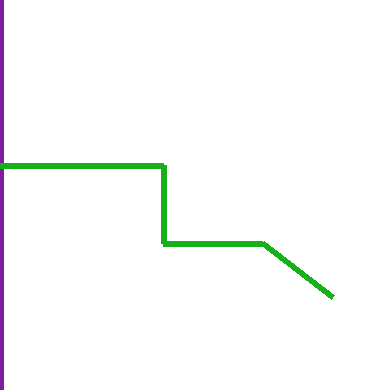

Ref stroke 0 vs Candidate Stroke 2 - error: 323.33070933696905


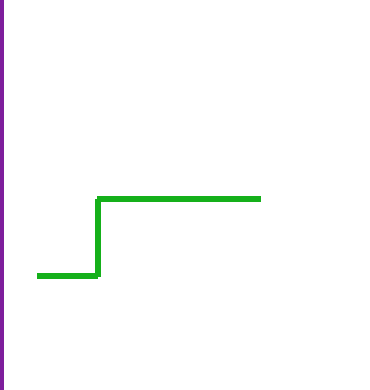

Ref stroke 0 vs Candidate Stroke 3 - error: 174.83823863226775


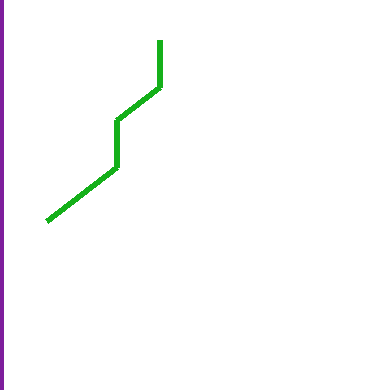

Ref stroke 0 vs Candidate Stroke 4 - error: 372.0493884298642


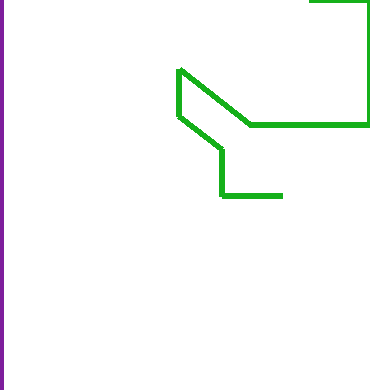

Ref stroke 1 vs Candidate Stroke 0 - error: 390.35637156094566


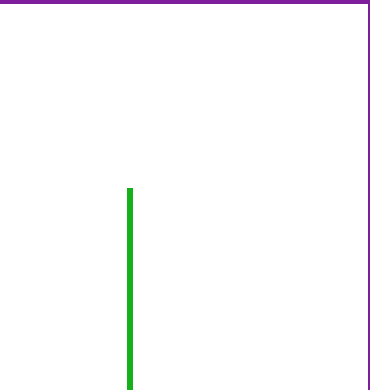

Ref stroke 1 vs Candidate Stroke 1 - error: 297.5827679128848


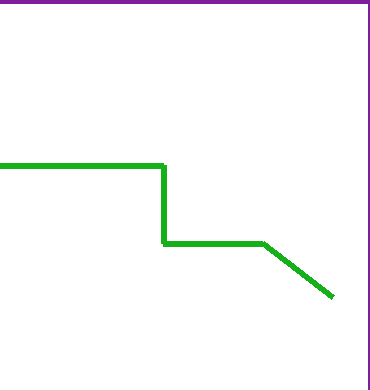

Ref stroke 1 vs Candidate Stroke 2 - error: 330.1412008211979


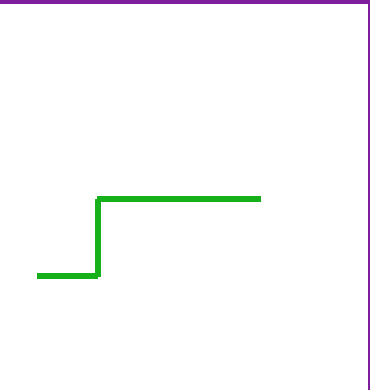

Ref stroke 1 vs Candidate Stroke 3 - error: 363.762881881278


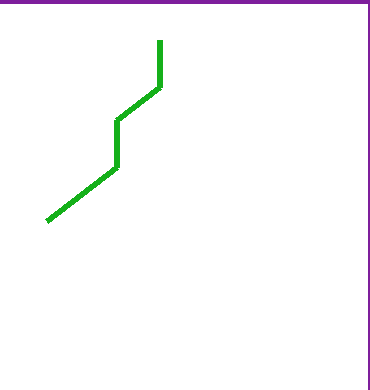

Ref stroke 1 vs Candidate Stroke 4 - error: 309.90933413504433


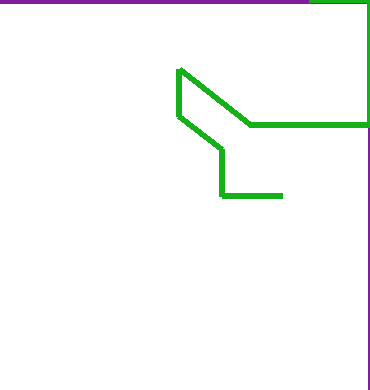

Ref stroke 2 vs Candidate Stroke 0 - error: 199.72879497394905


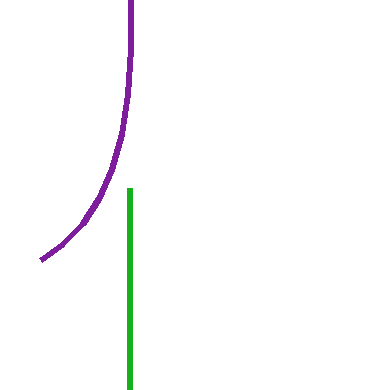

Ref stroke 2 vs Candidate Stroke 1 - error: 294.91286518268464


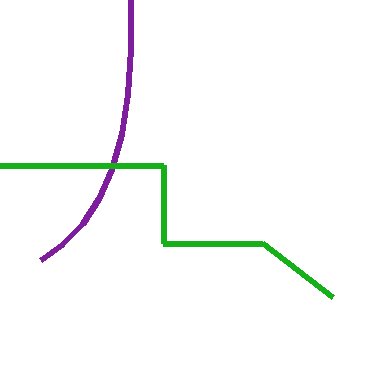

Ref stroke 2 vs Candidate Stroke 2 - error: 238.31460587037813


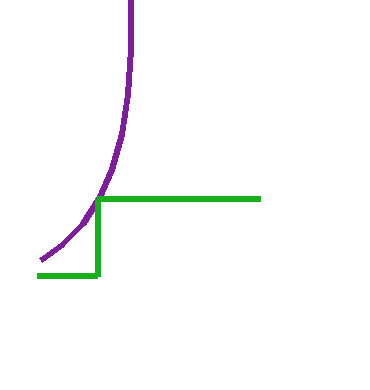

Ref stroke 2 vs Candidate Stroke 3 - error: 50.205645706145106


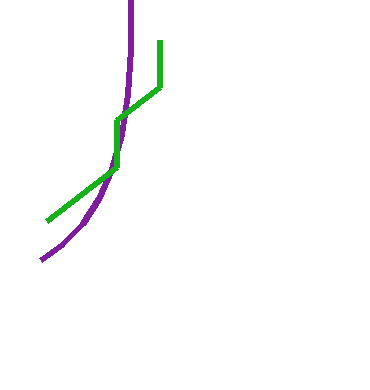

Ref stroke 2 vs Candidate Stroke 4 - error: 250.5594354834127


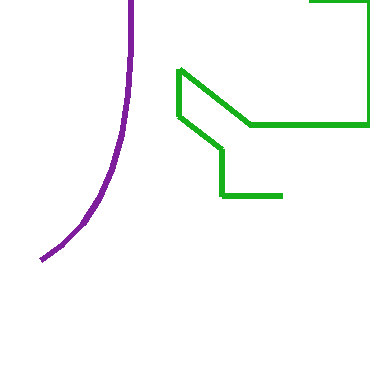

Ref stroke 3 vs Candidate Stroke 0 - error: 283.0983233911977


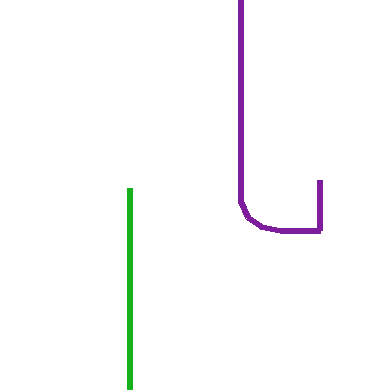

Ref stroke 3 vs Candidate Stroke 1 - error: 291.79525916550807


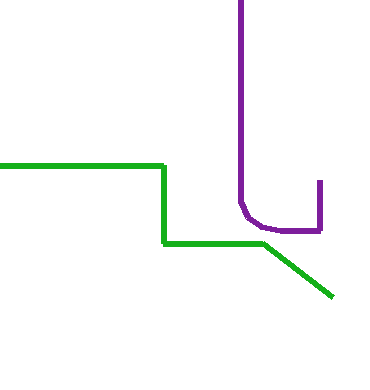

Ref stroke 3 vs Candidate Stroke 2 - error: 298.45892112475264


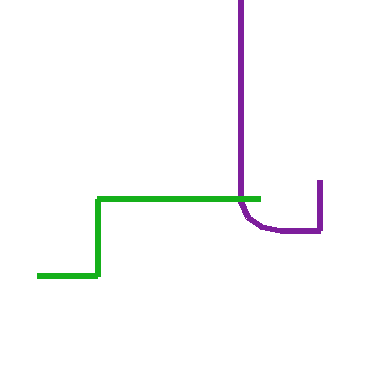

Ref stroke 3 vs Candidate Stroke 3 - error: 275.68430598467023


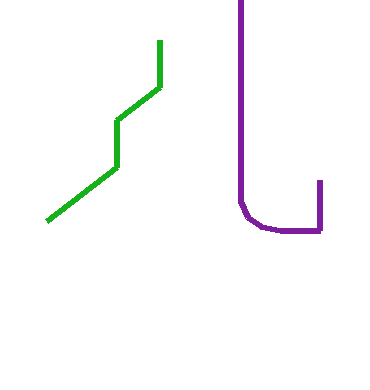

Ref stroke 3 vs Candidate Stroke 4 - error: 163.1603535858348


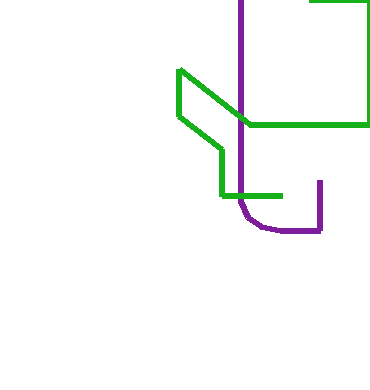

Ref stroke 4 vs Candidate Stroke 0 - error: 245.01039192185752


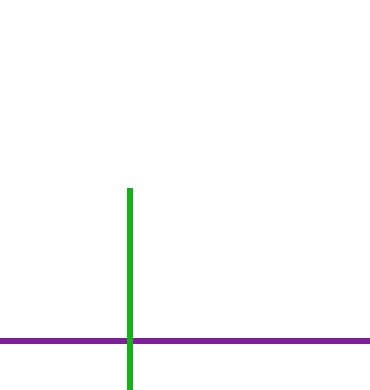

Ref stroke 4 vs Candidate Stroke 1 - error: 175.4587558152211


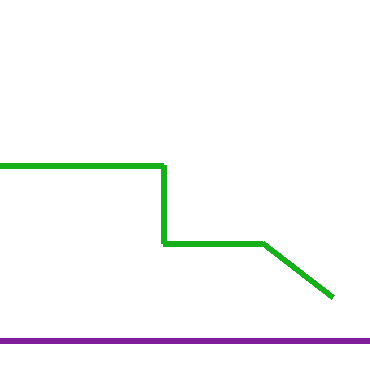

Ref stroke 4 vs Candidate Stroke 2 - error: 178.15906928009338


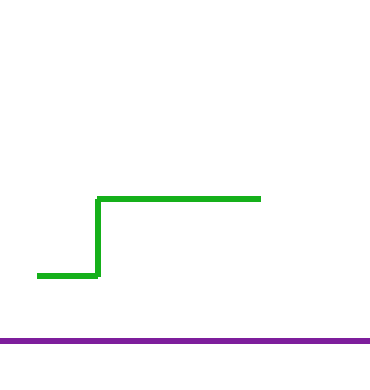

Ref stroke 4 vs Candidate Stroke 3 - error: 343.50695047714663


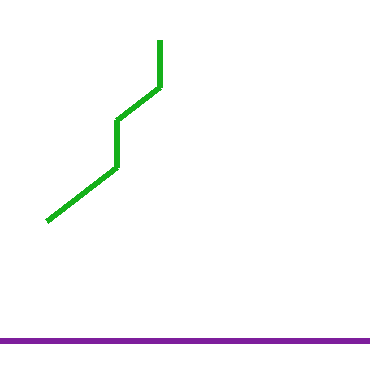

Ref stroke 4 vs Candidate Stroke 4 - error: 345.2692979749195


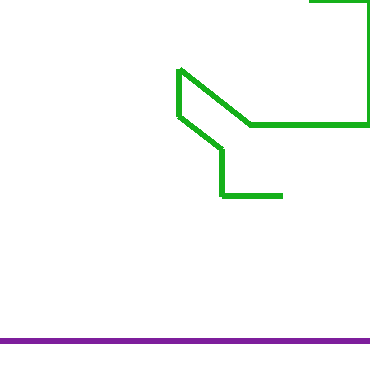

[[229 344 323 174 372]
 [390 297 330 363 309]
 [199 294 238  50 250]
 [283 291 298 275 163]
 [245 175 178 343 345]]
[390 297 330 363 309] - minimizing for priority stroke 1
Resulting error map:
[[  229 10000   323   174   372]
 [  390 10000   330   363   309]
 [  199 10000   238    50   250]
 [  283 10000   298   275   163]
 [  245 10000   178   343   345]]
[-1  1 -1 -1 -1]
[  229 10000   323   174   372] - minimizing for priority stroke 0
Resulting error map:
[[  229 10000   323 10000   372]
 [  390 10000   330 10000   309]
 [  199 10000   238 10000   250]
 [  283 10000   298 10000   163]
 [  245 10000   178 10000   345]]
[-1  1 -1  0 -1]
[  245 10000   178 10000   345] - minimizing for priority stroke 4
Resulting error map:
[[  229 10000 10000 10000   372]
 [  390 10000 10000 10000   309]
 [  199 10000 10000 10000   250]
 [  283 10000 10000 10000   163]
 [  245 10000 10000 10000   345]]
[-1  1  4  0 -1]
[  283 10000 10000 10000   163] - minimizing for priority stroke 3
Resulting erro

In [5]:
alignments = alignStrokes(g, ref_g, l, ref_l)
print(alignments)

[2 1 4 0 3]


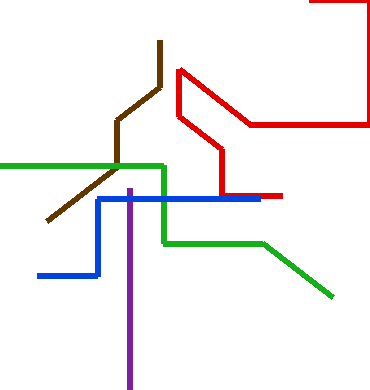

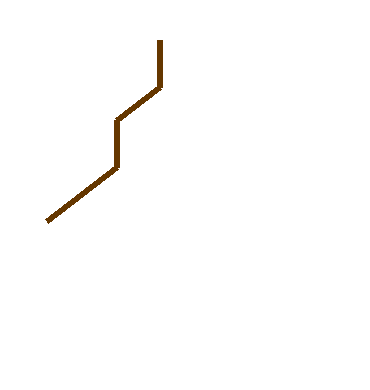

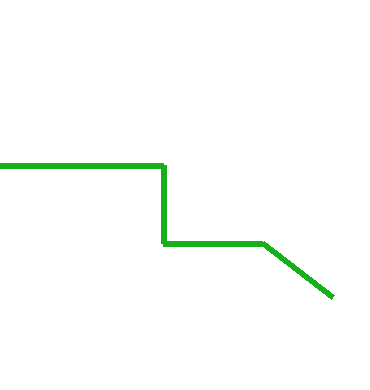

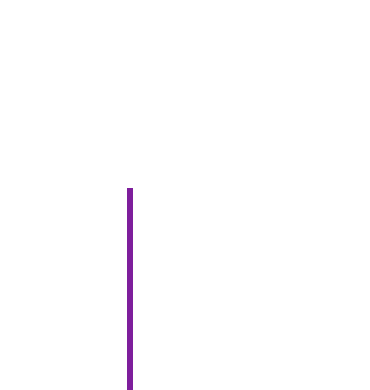

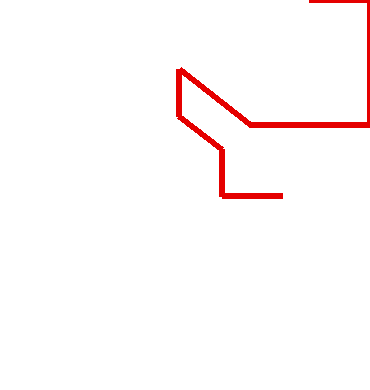

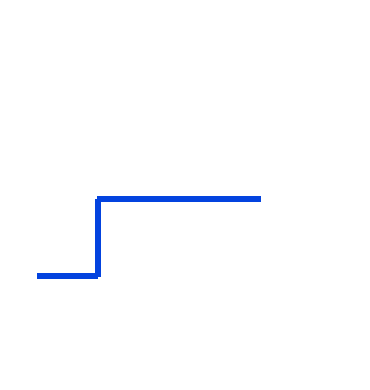

[2 1 4 0 3]


In [9]:
imgs = [Image.new(mode="RGBA", size=output_size) for _ in range(len(ref_g))]
img_full = Image.new(mode="RGBA", size=output_size)
seed(ref_l[0][0])
xcolors = ["#7e1e9c", "#15b01a", "#0343df", "#653700", "#e50000", "#f97306", "#033500", "#ffff14", "#001146"]
color_selection = [(int(c[1:3], 16), int(c[3:5], 16), int(c[5:7], 16)) for c in xcolors]
colors = color_selection[:len(ref_l)+1]
#colors = [(randint(0, 256), randint(0, 256), randint(0, 256)) for _ in range(len(ref_l)+1)]
colors_t = [(c[0], c[1], c[2], 70) for c in colors]


print(alignments)
for x in range(len(alignments)):
    i = np.where(alignments == x)[0][0]
    draw = ImageDraw.Draw(imgs[x])
    draw_full = ImageDraw.Draw(img_full)
    for a in range(len(g[i])-1):
        x1, y1 = g[i][a]
        x2, y2 = g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=6, fill=colors[i])
        draw_full.line(((x1, y1), (x2, y2)), width=6, fill=colors[i])

"""
for i in range(len(alignments)):
    draw = ImageDraw.Draw(imgs[i])
    draw_full = ImageDraw.Draw(img_full)
    for a in range(len(ref_g[i])-1):
        x1, y1 = ref_g[i][a]
        x2, y2 = ref_g[i][a+1]
        y1 = -(y1-output_size[1]/2)+output_size[1]/2
        y2 = -(y2-output_size[1]/2)+output_size[1]/2
        draw.line(((x1, y1), (x2, y2)), width=3, fill=colors[i])
        draw_full.line(((x1, y1), (x2, y2)), width=3, fill=colors[i])
"""
    
display(img_full)
for p in range(len(alignments)):
    display(imgs[p])
    
print(alignments)